In [1]:
import flexynesis 
import torch, os
torch.set_num_threads(12)

In [2]:
if not os.path.exists("dataset1"):
    !wget -O ccle_gdsc.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/dataset1.tgz" && tar -xzvf ccle_gdsc.tgz

In [3]:
data_importer = flexynesis.DataImporter(path ='./dataset1/', 
                                       data_types = ['gex', 'cnv'], 
                                        concatenate=False, min_features=1000, top_percentile=0.25)

In [4]:
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing ./dataset1/train/cnv.csv...
[INFO] Importing ./dataset1/train/clin.csv...
[INFO] Importing ./dataset1/train/gex.csv...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing ./dataset1/test/cnv.csv...
[INFO] Importing ./dataset1/test/clin.csv...
[INFO] Importing ./dataset1/test/gex.csv...

[INFO] ---------- Processing Data (train) ----------

[INFO] --------------- Cleaning Up Data ---------------
Number of NA values:  0
[INFO] DataFrame gex - Removed 0 features.
Number of NA values:  0
[INFO] DataFrame cnv - Removed 0 features.
DataFrame gex - Removed 0 samples (0.00%).
DataFrame cnv - Removed 0 samples (0.00%).
Implementing feature selection using laplacian score for layer: gex with  3422 features


Calculating Laplacian scores: 100%|██████████| 3422/3422 [00:00<00:00, 15431.64it/s]
Removing redundant features among top scoring ones: 100%|██████████| 1342/1342 [00:00<00:00, 1782.94it/s]


Implementing feature selection using laplacian score for layer: cnv with  157 features
Returning original matrix, demanded # of features is  larger than existing number of features

[INFO] ---------- Processing Data (test) ----------

[INFO] --------------- Cleaning Up Data ---------------
Number of NA values:  0
[INFO] DataFrame gex - Removed 0 features.
Number of NA values:  0
[INFO] DataFrame cnv - Removed 0 features.
DataFrame gex - Removed 0 samples (0.00%).
DataFrame cnv - Removed 0 samples (0.00%).

[INFO] ------------ Harmonizing Data Sets ------------

[INFO] --------------- Normalizing Data ---------------

[INFO] --------------- Normalizing Data ---------------
[INFO] Data import successful.


In [14]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "Erlotinib",
                                        config_name = "DirectPred", 
                                        config_path = './conf.yaml',
                                        n_iter=5, plot_losses=True)    

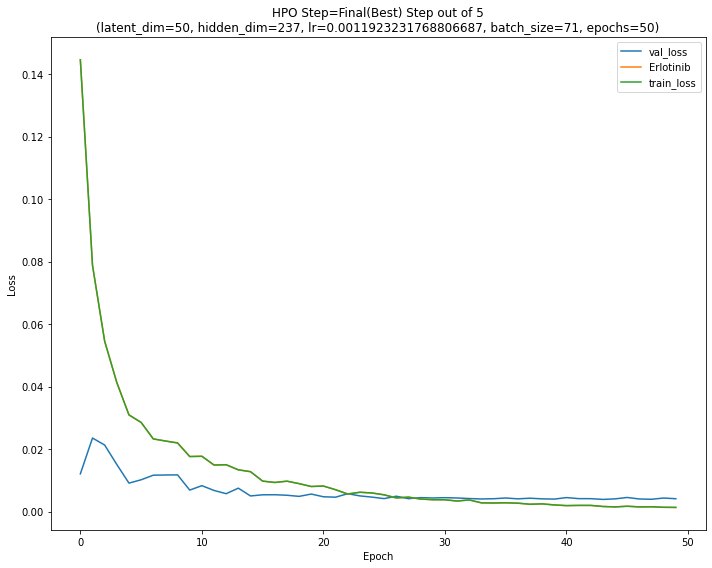

`Trainer.fit` stopped: `max_epochs=50` reached.


{'latent_dim': 50,
 'hidden_dim': 237,
 'lr': 0.0011923231768806687,
 'batch_size': 71,
 'epochs': 50}

In [15]:
model, best_params = tuner.perform_tuning()
best_params

In [16]:
y_pred_dict = model.predict(test_dataset)

In [17]:
metrics_df = flexynesis.evaluate_wrapper(y_pred_dict, test_dataset)
metrics_df

,var,variable_type,metric,value
0,Erlotinib,numerical,mse,0.004886
1,Erlotinib,numerical,r2,0.216085
2,Erlotinib,numerical,pearson_corr,0.477957


In [18]:
for var in model.target_variables:
    model.compute_feature_importance(var, steps = 50)

In [19]:
top_features = flexynesis.get_important_features(model, "Erlotinib", top=10)

In [20]:
top_features

,target_variable,target_class,layer,name,importance
0,Erlotinib,0,cnv,EGFR,0.002404
1,Erlotinib,0,gex,EGFR,0.002252
2,Erlotinib,0,cnv,RNASE2,0.001842
3,Erlotinib,0,cnv,EPS15,0.001643
4,Erlotinib,0,cnv,PLEKHA5,0.001634
5,Erlotinib,0,gex,ALDH1A1,0.001523
6,Erlotinib,0,gex,AGO2,0.001514
7,Erlotinib,0,gex,DTX2,0.001497
8,Erlotinib,0,gex,CADM1,0.001394
9,Erlotinib,0,cnv,NPY4R,0.001391


In [21]:
df = test_dataset.get_feature_subset(top_features)
df

,cnv_EGFR,cnv_RNASE2,cnv_EPS15,cnv_PLEKHA5,cnv_NPY4R,gex_EGFR,gex_ALDH1A1,gex_AGO2,gex_DTX2,gex_CADM1
target_dataset:HCC1937,-0.107248,0.276354,-1.304708,0.173883,-0.663288,0.580563,0.251614,0.820018,0.786468,-0.998805
target_dataset:NB4,1.059630,0.770449,0.852465,3.362489,2.697098,-1.179038,-0.773603,-0.368943,1.147520,-1.071844
target_dataset:A101D,-0.807375,-0.585729,-0.680397,-0.653123,-0.450061,-0.482084,-0.057275,-0.716167,-0.608511,0.911154
target_dataset:KALS-1,0.074266,0.493425,1.796546,0.125760,0.265482,-0.428795,-0.677500,-1.345588,-1.315077,0.210449
target_dataset:Ku812,-1.536674,-0.312840,-0.314946,-1.433787,-0.140470,-0.885480,1.906289,2.229944,-1.041892,-1.049926
...,...,...,...,...,...,...,...,...,...,...
target_dataset:NCI-H1373,0.135851,0.737371,1.040266,1.175558,0.616078,1.361843,-0.763995,0.922763,1.839393,-0.990670
target_dataset:A2058,0.012681,-0.631211,-0.657556,-0.651340,-0.607931,-1.162247,0.025526,0.543510,-1.111948,1.067683
target_dataset:HL-60,-0.922442,-0.463756,-0.708313,-0.628170,-0.491066,-0.797156,-0.727051,0.765245,-0.036600,-0.836241
target_dataset:U-937,-0.836547,-0.610537,-0.756532,-0.676293,-0.489016,-1.137066,-0.656658,-0.312955,-0.304754,-0.903114


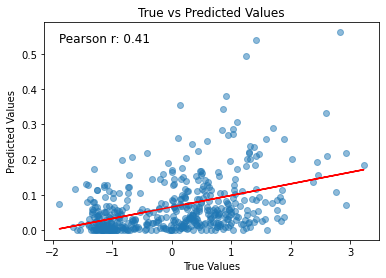

In [23]:
f = 'gex_EGFR'
flexynesis.plot_scatter(df[f], test_dataset.ann['Erlotinib'])

In [25]:
response_category = flexynesis.split_by_median(test_dataset.ann['Erlotinib'])

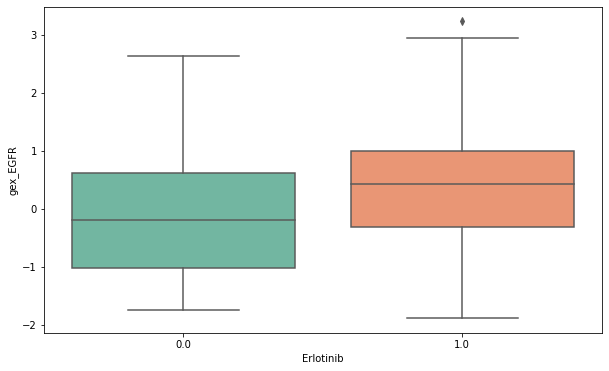

In [26]:
flexynesis.plot_boxplot(response_category, df[f], 'Erlotinib', f)

In [27]:
# get embeddings from training data
E = model.transform(test_dataset)

In [ ]:
flexynesis.plot_dim_reduced(E, labels = response_category, method='umap', color_type='numerical')